In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras import backend
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from itertools import product as myzip

We import our data into a dictionary, the keys of which describe the splitting.

In [2]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [3]:
def format_fn(path):
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [4]:
for dataset in datasets:
    x_paths = glob.glob(my_path + dataset + '\*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '\*.png')
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

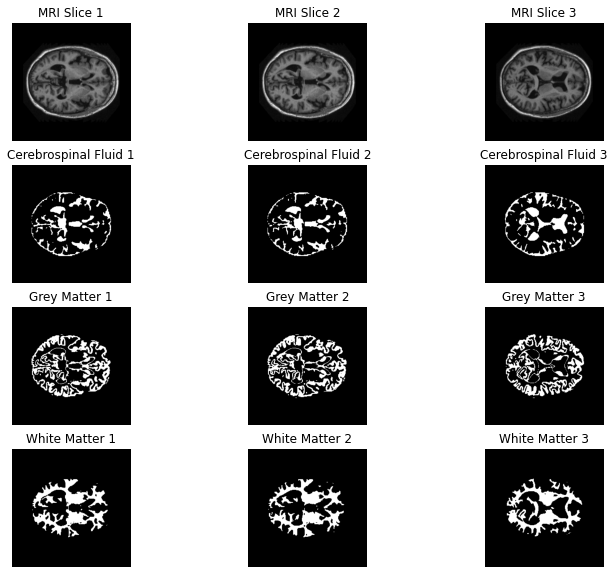

In [5]:
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
x_sample = tf.reshape(x_sample, [3, 256, 256])
y_sample = tf.reshape(y_sample, [3, 256, 256, 4])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

Next we build subclasses for the UNet layers we will need, ```Downshift``` for downsampling and ```Upshift``` for upsampling sections.

In [6]:
class My_Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel=3, dropout=.3):
        super(My_Conv2D, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, kernel, activation='relu', padding='same')
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        
    def call(self, x):
        x = self.conv2d_1(x)
        x = self.dropout_1(x)
        
        return x

class Downshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Downshift, self).__init__()
        self.conv2d_1 = My_Conv2D(filters)
        self.conv2d_2 = My_Conv2D(filters)
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(padding='same')
        
    def call(self, x):
        x = self.conv2d_1(x)
        x_res = self.conv2d_2(x)
        x = self.maxpool_1(x_res)
        
        return x, x_res
    
class Upshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Upshift, self).__init__()
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = My_Conv2D(filters)
        self.concatenate_1 = tf.keras.layers.Concatenate()
        self.conv2d_2 = My_Conv2D(filters)
        self.conv2d_3 = My_Conv2D(filters)
        
    def call(self, x, res):
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1([res, x])
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        
        return x

We will use the Jaccard distance (1 - IoU) as an objective function.

In [8]:
def jaccard_distance(y_ground, y_predicted):
    intersection = backend.sum(backend.abs(y_ground * y_predicted), axis=-1)
    union = backend.sum(backend.abs(y_ground) + backend.abs(y_predicted), axis=-1)
    jaccard_index = (intersection) / (union - intersection)
    
    return 1 - jaccard_index

Before building a larger model, we first test our concept on a smaller scale.

In [7]:
class My_Simple_Model(tf.keras.Model):
    def __init__(self):
        super(My_Simple_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        
        self.downshift_1 = Downshift(40)
        self.upshift_1 = Upshift(40)
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='sigmoid', padding='same')
        
    def call(self, x_0, training=False):
        x_1 = self.input_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3 = self.upshift_1(x_2, x_2_res)
        
        x_4 = self.output_1(x_3)
        
        return x_4

In [13]:
simple_model = My_Simple_Model()

my_opt = adam(lr=10**-3)

simple_model.compile(optimizer=my_opt, 
              loss=jaccard_distance,
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

simple_model.build(input_shape=(None, 256, 256, 1))

simple_model.summary()

Model: "my__simple__model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [None]                    0         
_________________________________________________________________
downshift_2 (Downshift)      multiple                  14840     
_________________________________________________________________
upshift_2 (Upshift)          multiple                  57720     
_________________________________________________________________
conv2d_17 (Conv2D)           multiple                  164       
Total params: 72,724
Trainable params: 72,724
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = simple_model.fit(data_dict['train'].batch(10), epochs=1,
                    validation_data=data_dict['validate'].batch(10), verbose=1)

Train for 967 steps, validate for 112 steps
967/967 [==============================] - 177s 183ms/step - loss: 0.1965 - mean_io_u_2: 0.7853 - val_loss: 0.1129 - val_mean_io_u_2: 0.8596


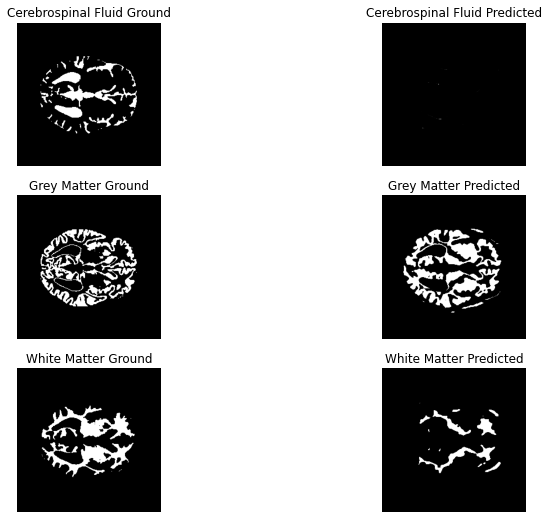

In [15]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = simple_model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

Not bad for a single epoch; onto the larger model. Scaling up, we change to the smoothed Jaccard distance. We suppose that the smoothed Jaccard distance has the same optima as the Jaccard distance (similar to a log likelihood) but avoids the problem of vanishing/exploding gradients.

In [7]:
def smoothed_jaccard_distance(y_ground, y_predicted, smoothing=100):
    intersection = backend.sum(backend.abs(y_ground*y_predicted), axis=-1)
    union = backend.sum(backend.abs(y_ground) + backend.abs(y_predicted), axis=-1)
    jaccard_index = (intersection + smoothing)/(union - intersection + smoothing)
    
    return (1 - jaccard_index)*smoothing

In [8]:
class My_Larger_Model(tf.keras.Model):
    def __init__(self):
        super(My_Larger_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        
        self.downshift_1 = Downshift(64)
        self.downshift_2 = Downshift(128)
        
        self.deepconv2d_1 = My_Conv2D(256)
        self.deepconv2d_2 = My_Conv2D(256)
        
        self.upshift_2 = Upshift(128)
        self.upshift_3 = Upshift(64)
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='sigmoid', padding='same')
        
    def call(self, x_0, training=False):
        x_1 = self.input_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3, x_3_res = self.downshift_2(x_2)
        
        x_4 = self.deepconv2d_1(x_3)
        x_5 = self.deepconv2d_2(x_4)

        x_6 = self.upshift_2(x_5, x_3_res)
        x_7 = self.upshift_3(x_6, x_2_res)
        

        x_8 = self.output_1(x_7)
        
        return x_8

In [12]:
larger_model = My_Larger_Model()

my_opt = adam(lr=10**-3)

larger_model.compile(optimizer=my_opt, 
              loss=smoothed_jaccard_distance,
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

larger_model.build(input_shape=(None, 256, 256, 1))

larger_model.summary()

Model: "my__larger__model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [None]                    0         
_________________________________________________________________
downshift_2 (Downshift)      multiple                  37568     
_________________________________________________________________
downshift_3 (Downshift)      multiple                  221440    
_________________________________________________________________
my__conv2d_16 (My_Conv2D)    multiple                  295168    
_________________________________________________________________
my__conv2d_17 (My_Conv2D)    multiple                  590080    
_________________________________________________________________
upshift_2 (Upshift)          multiple                  737664    
_________________________________________________________________
upshift_3 (Upshift)          multiple          

In [13]:
history = larger_model.fit(data_dict['train'].batch(10), epochs=5,
                    validation_data=data_dict['validate'].batch(10), verbose=1)

Train for 967 steps, validate for 112 steps
Epoch 1/5
967/967 [==============================] - 411s 425ms/step - loss: 0.5476 - mean_io_u_1: 0.6969 - val_loss: 0.5439 - val_mean_io_u_1: 0.6982
Epoch 2/5
967/967 [==============================] - 471s 487ms/step - loss: 0.5440 - mean_io_u_1: 0.6982 - val_loss: 0.5439 - val_mean_io_u_1: 0.6982
Epoch 3/5
967/967 [==============================] - 446s 461ms/step - loss: 0.5440 - mean_io_u_1: 0.6982 - val_loss: 0.5439 - val_mean_io_u_1: 0.6982
Epoch 4/5
967/967 [==============================] - 437s 452ms/step - loss: 0.5494 - mean_io_u_1: 0.6962 - val_loss: 0.5439 - val_mean_io_u_1: 0.6982
Epoch 5/5
967/967 [==============================] - 405s 419ms/step - loss: 0.5569 - mean_io_u_1: 0.6935 - val_loss: 0.5439 - val_mean_io_u_1: 0.6982


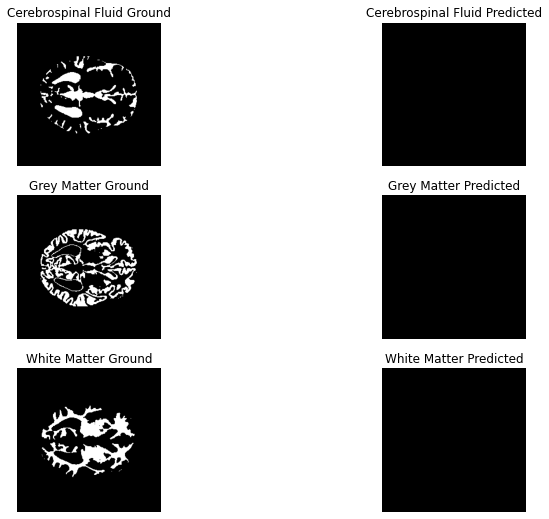

In [14]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = larger_model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()